# ScGeo PBMC ingest demo (rebuilt)

This notebook is a **practical, Scanpy-first walkthrough** that ends with **ScGeo geometry-aware QC** on an integrated PBMC embedding.

You will:
1. Load a PBMC reference dataset and a "query" split.
2. Run a standard Scanpy preprocessing + neighbor graph workflow.
3. Produce an embedding (UMAP) that we can use for visualization.
4. Compute a **consensus subspace score** (cs_score) that highlights *cells that most strongly drive* the separation between conditions.
5. (Optional) Run **graph-native mapping** (`sg.tl.map_query_to_ref`) and interpret **predicted label / confidence / OOD** QC outputs.

The goal is not to claim biological discovery from a toy example, but to show how ScGeo’s outputs behave and *how to reason about them* on a familiar dataset.



## 0) Imports and small helpers

We keep the imports explicit so the notebook is easy to reuse.

**Key objects used throughout:**
- `adata`: a single AnnData that contains both **reference** and **query** cells.
- `condition_key`: an `.obs` column that marks whether a cell is in the reference or query partition.
- `label_key`: an `.obs` column that we want to *transfer/predict* from ref → query (e.g., `louvain` or curated `cell_type`).

> In this demo, you’ll often see `louvain` used as the label key because it exists in most Scanpy PBMC tutorials.
> If you have a curated annotation (e.g. `cell_type`), using that is usually more biologically interpretable.



## 1) Load PBMC data and define a toy "ref/query" split

PBMC is a convenient sanity-check dataset because:
- the major immune populations are well-separated (T cells, B cells, NK, monocytes, etc.)
- many pipelines can reproduce the same coarse structure even with different preprocessing details

**Important:** in this notebook the “query” is not an external dataset — it is a **partition of the same dataset**.
So you should expect mapping to be *mostly* coherent (because biology is shared), and deviations are mainly due to noise / graph choices / parameter choices.



In [1]:
import scgeo as sg
import scanpy as sc
import numpy as np

# Optional: make plots a bit larger
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120


## 2) Basic Scanpy preprocessing (high level intuition)

This is a standard Scanpy recipe:

1. **Normalize** counts per cell so cells become comparable.
2. **Log-transform** to compress heavy tails.
3. Select **highly variable genes (HVGs)** to focus on informative variation.
4. Run **PCA** for denoising + dimensionality reduction.
5. Build a **kNN graph** (stored in `adata.obsp['connectivities']` and `adata.obsp['distances']`).
6. Compute **UMAP** for visualization.

ScGeo’s QC tools are **graph-native**: they often assume a neighbor graph exists.
That’s why later, if your notebook hasn’t built a graph yet, running `sc.pp.neighbors(adata)` is the right move.



In [2]:
# --- Paste your PBMC data loading + preprocessing here ---
# Expectation at the end: a variable named `ad` (AnnData)
adata_ref = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc68k_reduced()
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names].copy()
adata = adata[:, var_names].copy()
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.tl.ingest(adata, adata_ref, obs="louvain")
ad = sc.concat({"ref": adata_ref, "new": adata}, label="batch", join="outer", merge="same")

# Example checklist (keep as asserts):
assert 'batch' in ad.obs, "Need ad.obs['batch'] with two groups (ref/new)."
assert 'X_pca' in ad.obsm, "Need PCA embedding in ad.obsm['X_pca']."
assert 'X_umap' in ad.obsm, "Need UMAP embedding in ad.obsm['X_umap']."


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [3]:
ad

AnnData object with n_obs × n_vars = 3338 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'bulk_labels', 'S_score', 'G2M_score', 'phase', 'batch'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'rep'

## 3) Clustering / labels for interpretation

We need a label column for two reasons:

- **Human interpretation:** cluster labels help you visually parse UMAP structure.
- **Mapping QC:** `map_query_to_ref` produces a *predicted label* for query cells by comparing their neighborhoods to reference labels.

If your dataset already has curated cell types, prefer those.
If not, using `louvain` is fine for a demo — just remember it is an **algorithmic partition**, not ground-truth biology.



In [4]:
# Condition definition
condition_key = 'batch'
group0 = 'ref'
group1 = 'new'

# Cluster key used for by=... analyses
cluster_key = 'louvain'  # change if you use leiden etc.
assert cluster_key in ad.obs, f"Missing ad.obs['{cluster_key}']"


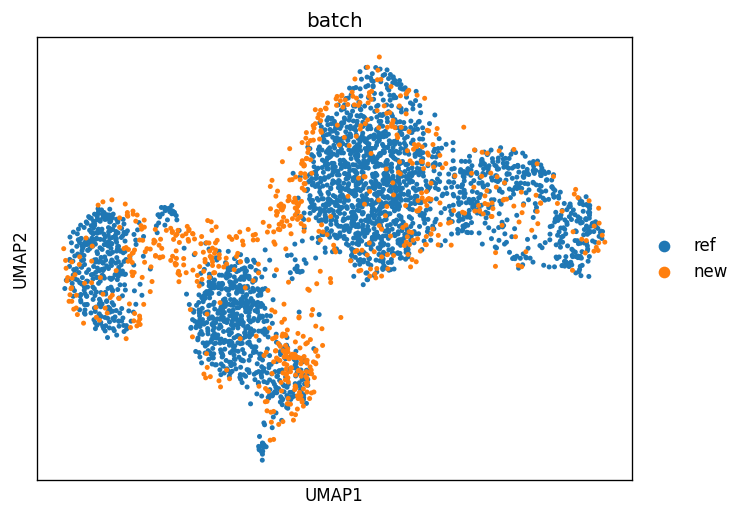

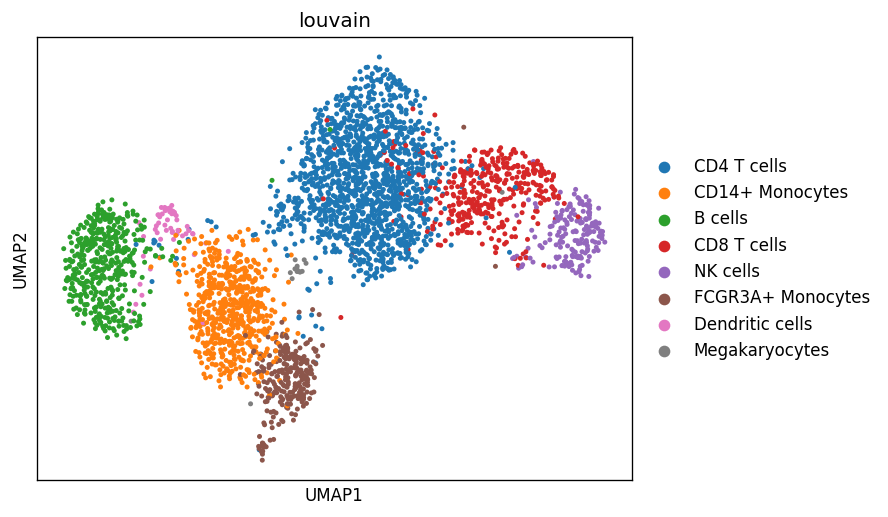

In [5]:
sc.pl.umap(ad, color='batch')
sc.pl.umap(ad,color='louvain')

## 4) ScGeo: consensus subspace and `cs_score`

### What is the “consensus subspace” idea?
In many comparative settings (condition A vs B, batch1 vs batch2, ref vs query), there is a **dominant direction** in embedding space that captures the most systematic separation.

ScGeo constructs a *low-dimensional subspace* (think: a few vectors) that summarizes this separation.

### What does `cs_score` mean?
`cs_score` is a **per-cell score** indicating how strongly each cell aligns with the learned separation direction(s).

Typical interpretation:
- **High cs_score**: cells that most strongly drive the condition difference (or are most aligned with it)
- **Low cs_score**: cells that are less informative for the condition contrast

**Important nuance:**
A high score does *not* automatically mean “most biologically important.” It means “most aligned with the separation the algorithm found,” which could reflect:
- a true biological program
- technical artifacts
- uneven mixing / integration issues

That’s why we always pair the score plot with QC (neighbors, mixing, mapping confidence, etc.).



In [6]:
sg.tl.shift(
    ad,
    rep='X_pca',
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=cluster_key,
    store_key='scgeo',
)


In [7]:
ad

AnnData object with n_obs × n_vars = 3338 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'bulk_labels', 'S_score', 'G2M_score', 'phase', 'batch'
    uns: 'batch_colors', 'louvain_colors', 'scgeo'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'rep'

<Axes: title={'center': 'ScGeo: delta magnitude ranking'}, xlabel='name', ylabel='||Δ||'>

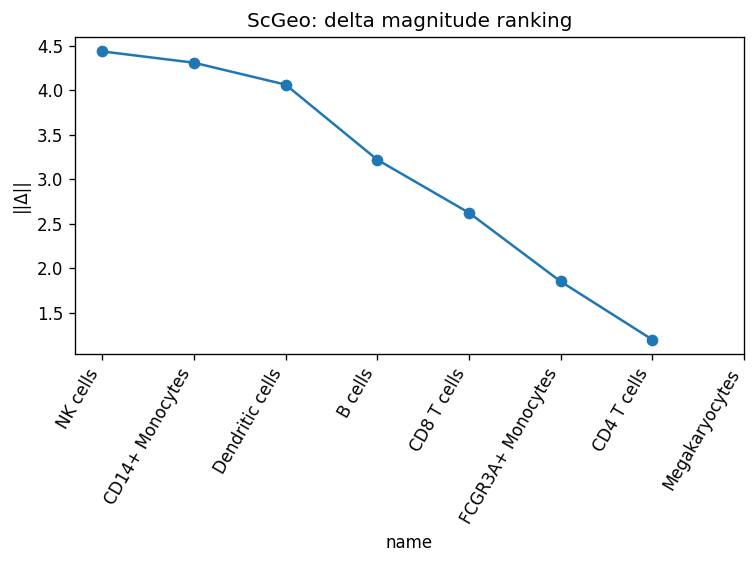

In [8]:
# Visual: which clusters have the biggest mean-shift magnitude?
sg.pl.delta_rank(ad, store_key="scgeo", kind="shift", level="by")


**Interpretation checklist (quick):**

- **Predicted label** should broadly track the UMAP manifolds.
- **Confidence** should be high in the centers of major populations and drop at boundaries.
- **OOD** should spike only for edge / rare / poorly supported regions in this toy example.

If predicted labels look biologically odd:
1. Confirm `label_key` is truly a *reference annotation* you trust (e.g., curated cell types > Louvain).
2. Confirm neighbors were computed on the intended representation (PCA / integrated embedding).
3. Consider whether the query partition is imbalanced or missing key populations.



## QC Block 1 — Geometry overlap and mixing (embedding-level sanity checks)

Here we run **overlap / distribution diagnostics** to quantify whether the reference and query occupy similar regions of the embedding.

What to look for:

- **Good mixing**: query points appear in the same local neighborhoods as reference points of the same state.
- **Bad mixing / shift**: query points form separate islands, or occupy only the “edges” of reference islands.
- **Partial mixing**: some populations mix well while others remain separated (often biology or protocol differences).

These diagnostics are intentionally *coarse* — they tell you where to zoom in, not the final biology.


## 4) Density overlap on UMAP: Bhattacharyya / Hellinger

**Why:** shift magnitude alone misses *distributional overlap*. Overlap metrics quantify how separable the two conditions are in an embedding.

**What it writes:** `adata.uns['scgeo']['density_overlap']` with `global` and `by` summaries.

In [9]:
sg.tl.density_overlap(
    ad,
    rep='X_umap',
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=cluster_key,
    store_key='scgeo',
)


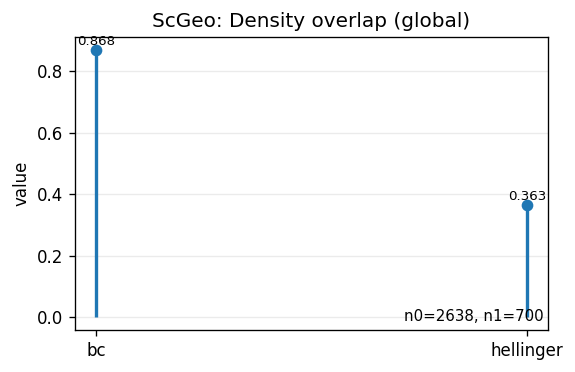

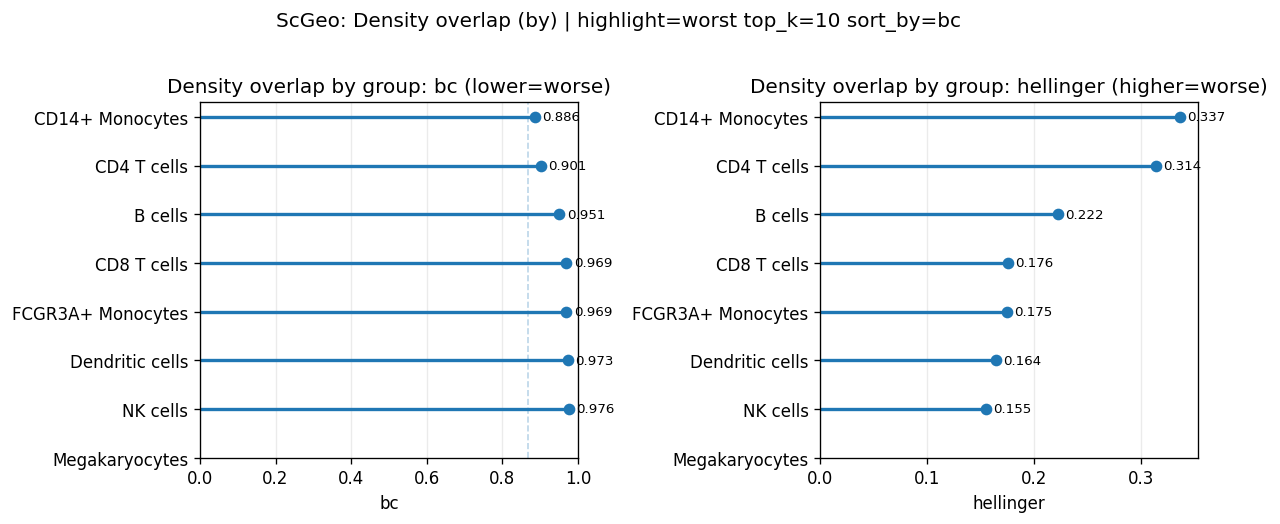

(<Figure size 1248x508.8 with 2 Axes>,
 array([<Axes: title={'center': 'Density overlap by group: bc (lower=worse)'}, xlabel='bc'>,
        <Axes: title={'center': 'Density overlap by group: hellinger (higher=worse)'}, xlabel='hellinger'>],
       dtype=object))

In [10]:
# Global + per-cluster summary bars
sg.pl.density_overlap(ad, store_key='density_overlap', level='global')
sg.pl.density_overlap(ad, store_key='density_overlap', level='by')


**Interpretation:**
- Higher BC overlap ⇒ more similar distributions.
- Higher Hellinger distance ⇒ more different distributions.

Note: `sg.pl.density_overlap_grid` requires grid fields that `tl.density_overlap` does not currently store. Use `sg.pl.embedding_density` instead to show spatial patterns.

## 5) Embedding density small-multiples (sanity check)

**Why:** quickly see where each cluster lives in UMAP and whether density shifts are plausible.

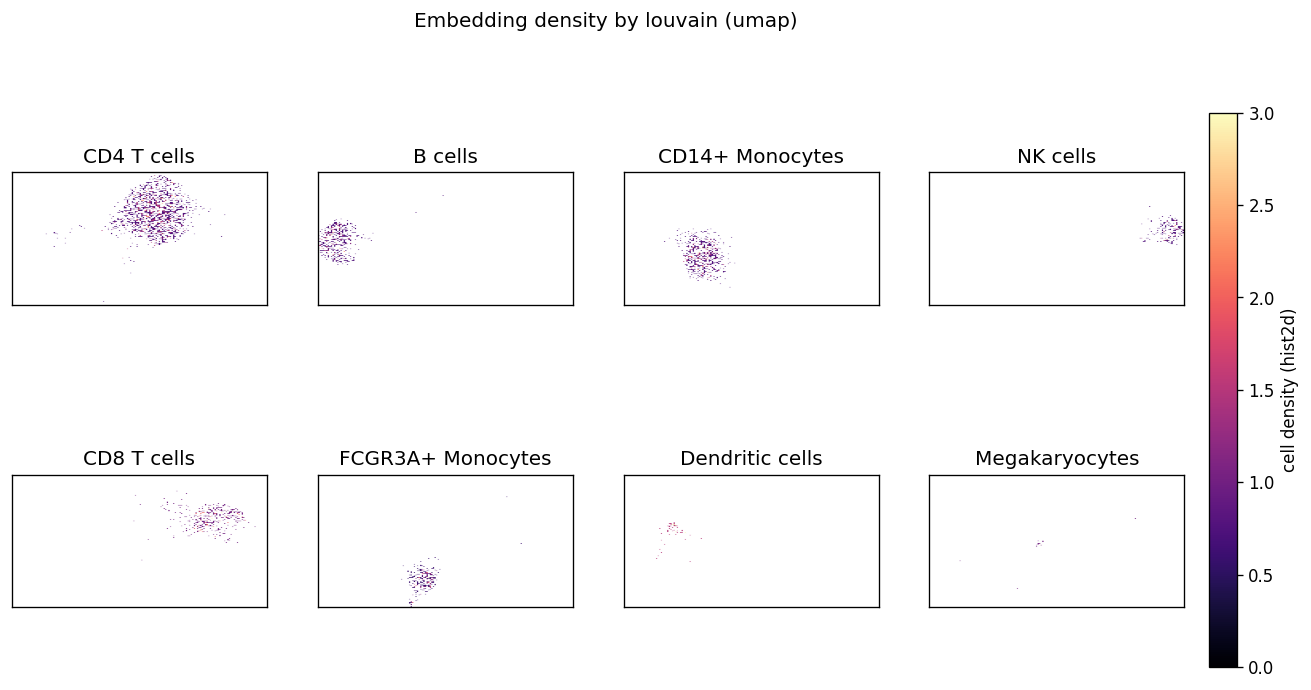

(<Figure size 1584x720 with 9 Axes>,
 array([<Axes: title={'center': 'CD4 T cells'}>,
        <Axes: title={'center': 'B cells'}>,
        <Axes: title={'center': 'CD14+ Monocytes'}>,
        <Axes: title={'center': 'NK cells'}>,
        <Axes: title={'center': 'CD8 T cells'}>,
        <Axes: title={'center': 'FCGR3A+ Monocytes'}>,
        <Axes: title={'center': 'Dendritic cells'}>,
        <Axes: title={'center': 'Megakaryocytes'}>], dtype=object))

In [11]:
sg.pl.embedding_density(
    ad,
    groupby=cluster_key,
    basis="umap",
    contour=False,
    background="white",
    mask_zeros=True,      # <-- critical
    imshow_alpha=1.0,

)



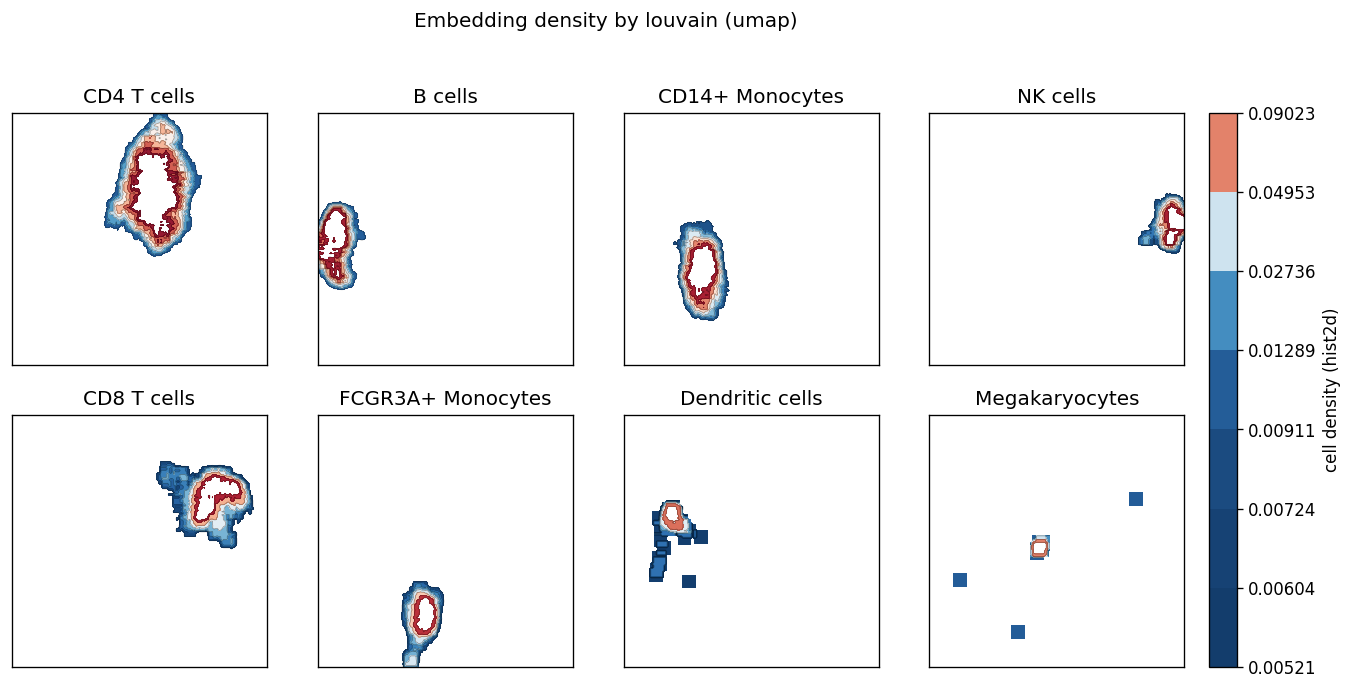

(<Figure size 1584x720 with 9 Axes>,
 array([<Axes: title={'center': 'CD4 T cells'}>,
        <Axes: title={'center': 'B cells'}>,
        <Axes: title={'center': 'CD14+ Monocytes'}>,
        <Axes: title={'center': 'NK cells'}>,
        <Axes: title={'center': 'CD8 T cells'}>,
        <Axes: title={'center': 'FCGR3A+ Monocytes'}>,
        <Axes: title={'center': 'Dendritic cells'}>,
        <Axes: title={'center': 'Megakaryocytes'}>], dtype=object))

In [12]:
sg.pl.embedding_density(
    ad,
    groupby=cluster_key,
    basis="umap",
    contour=True,
    smooth_k=9,
    contour_levels=8,
    contour_linewidth=0.5,
    mask_zeros=True,
    log1p=True,
    cmap='RdBu_r'
)


**Interpretation:** empty panels usually mean UMAP is missing or `cluster_key` has too many rare categories.

## QC Block 2 — Distribution tests (where exactly is geometry different?)

Overlap tells you *whether* things overlap. Distribution tests try to answer *how* they differ.

Typical interpretations:

- **Localized divergence** (one cluster or region): suggests a specific population is mismatched, novel, or shifted.
- **Global divergence** (many regions): suggests strong batch effects, different preprocessing, or different biological composition.
- **Asymmetric divergence**: query covers a subset of reference (or vice versa) → could be sampling depth, filtering, or true absence.


## 6) Distribution test (global + by cluster)

**Why:** provide a statistical test for distribution change beyond overlap heuristics.

**What it writes:** `adata.uns['scgeo']['distribution_test']` with `global` and `by` tables.

In [13]:
sg.tl.distribution_test(
    ad,
    rep='X_pca',
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=cluster_key,
    method='energy',
    n_perm=200,  # keep demo fast; increase for publication
    seed=0,
    store_key='scgeo',
)


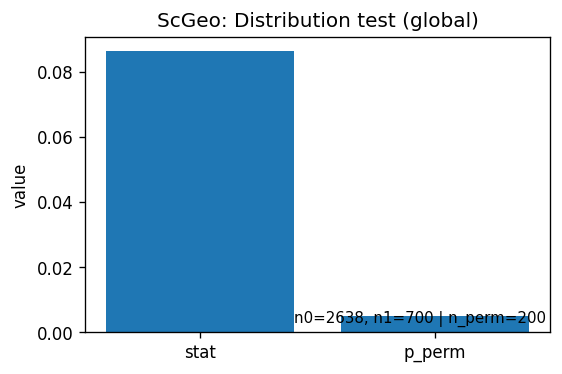

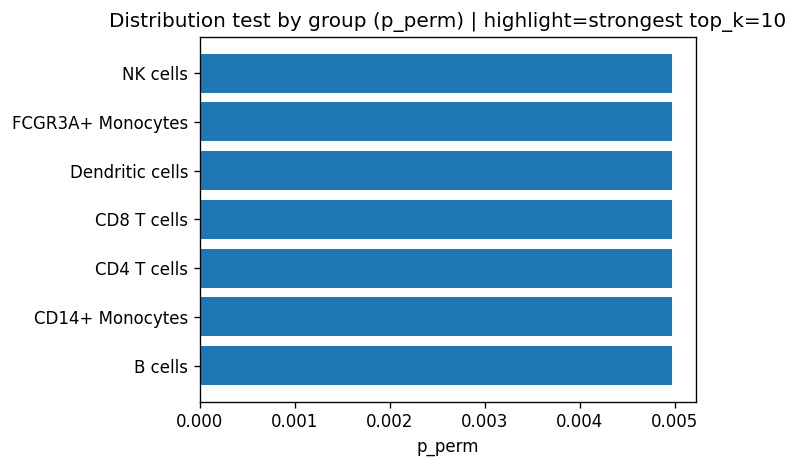

(<Figure size 720x480 with 1 Axes>,
 array([<Axes: title={'center': 'Distribution test by group (p_perm) | highlight=strongest top_k=10'}, xlabel='p_perm'>],
       dtype=object))

In [14]:
# Summary table plots
sg.pl.distribution_test(ad, store_key='distribution_test', level='global')
sg.pl.distribution_test(ad, store_key='distribution_test', level='by')


**Interpretation:** look for clusters with strong stats / low p-values.

If the volcano plot errors: it expects columns like `effect` and `p_adj`. Your current `tl.distribution_test` may not compute an effect size column yet; use the summary plot above until `effect` is standardized.

## QC Block 3 — Consensus subspace (a “direction” that summarizes systematic difference)

The **consensus subspace** compresses the difference between conditions into a small number of latent directions.

Intuition:

- Think of the embedding as a cloud.  
- The consensus subspace finds directions where the *condition-specific means / neighborhoods* differ consistently.
- Each cell gets a **cs_score** measuring how strongly it aligns with that learned direction.

Interpretation:

- **High cs_score cells** are the *most condition-aligned* — they are the best candidates to inspect for “what changed”.
- You still need to validate with markers / cell type labels; cs_score is a *geometry signal*, not a marker gene.

Practical tip:
- Use **top-k cs_score cells** as a “spotlight” for follow-up plots (markers, density panels, neighborhood composition).


## 7) Consensus subspace: multi-sample or per-group delta directions

**Why:** learn a low-dimensional *direction basis* that explains condition deltas (optionally sample-aware).

**What it writes:**
- `ad.obsm['X_cs']` (projections)
- `ad.obs['cs_score']` (magnitude / score)
- `ad.uns['consensus_subspace']` (vectors + metadata)

In [15]:
sg.tl.consensus_subspace(
    ad,
    rep='X_pca',
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    sample_key=None,   # set if you have donors/samples
    n_components=2,
    obs_key_prefix='cs',
    min_cells=20,
)


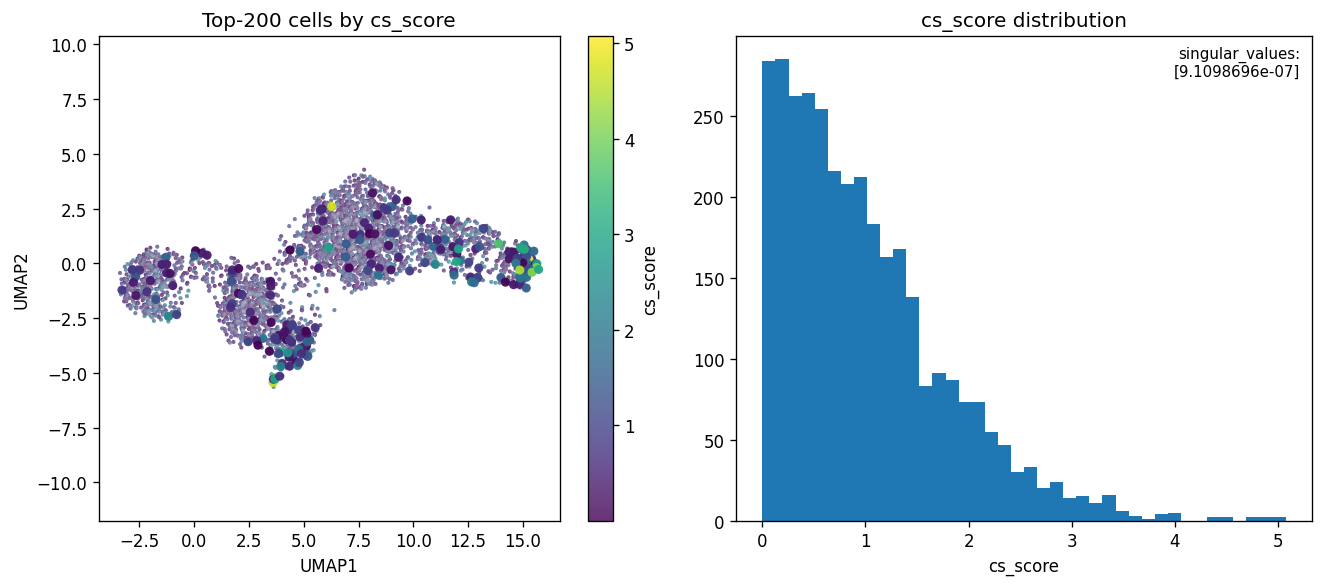

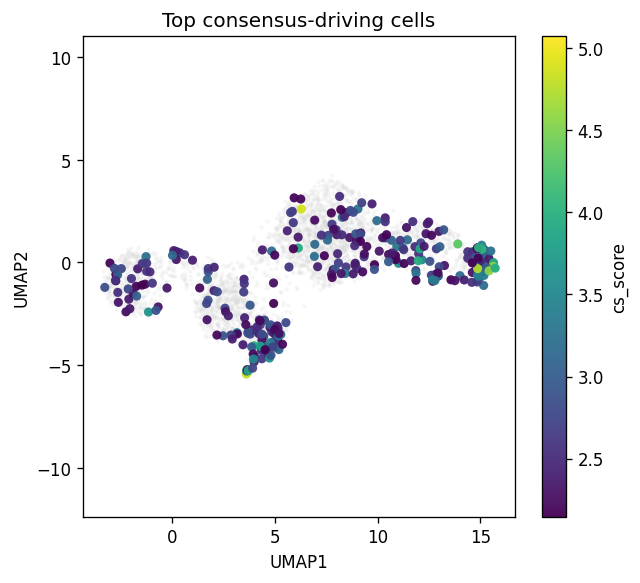

(<Figure size 696x624 with 2 Axes>,
 <Axes: title={'center': 'Top consensus-driving cells'}, xlabel='UMAP1', ylabel='UMAP2'>)

In [16]:
sg.pl.consensus_subspace_panel(ad, score_key='cs_score', basis='umap', topk=200)
sg.pl.highlight_topk_cells(ad, score_key='cs_score', basis='umap', topk=300, title='Top consensus-driving cells')


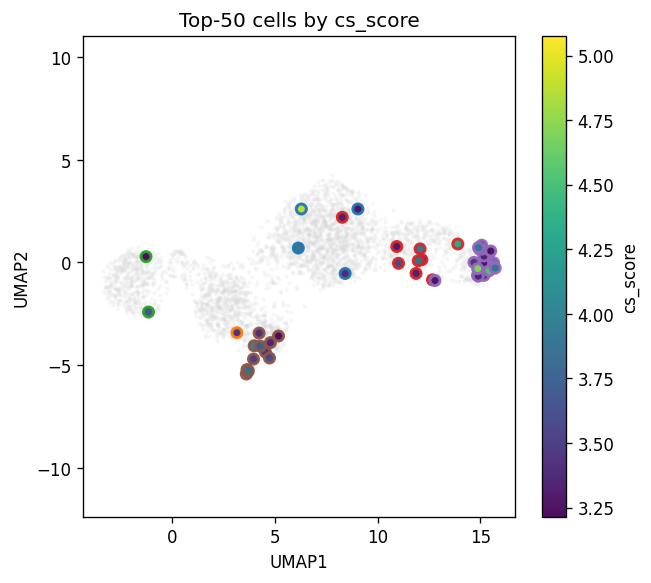

(<Figure size 696x624 with 2 Axes>,
 <Axes: title={'center': 'Top-50 cells by cs_score'}, xlabel='UMAP1', ylabel='UMAP2'>)

In [17]:
sg.pl.highlight_topk_cells(
    ad,
    score_key="cs_score",
    basis="umap",
    topk=50,
    groupby="louvain",
    outline_topk=True,
    hi_size=36,
    outline_lw=1.8,
)


[scgeo] consensus_structure legend (topk=100, groupby='louvain')
  - NK cells:  35.0% (35 / 100)
  - FCGR3A+ Monocytes:  23.0% (23 / 100)
  - CD8 T cells:  17.0% (17 / 100)
  - CD4 T cells:  12.0% (12 / 100)
  - B cells:   6.0% (6 / 100)
  - CD14+ Monocytes:   6.0% (6 / 100)
  - Dendritic cells:   1.0% (1 / 100)


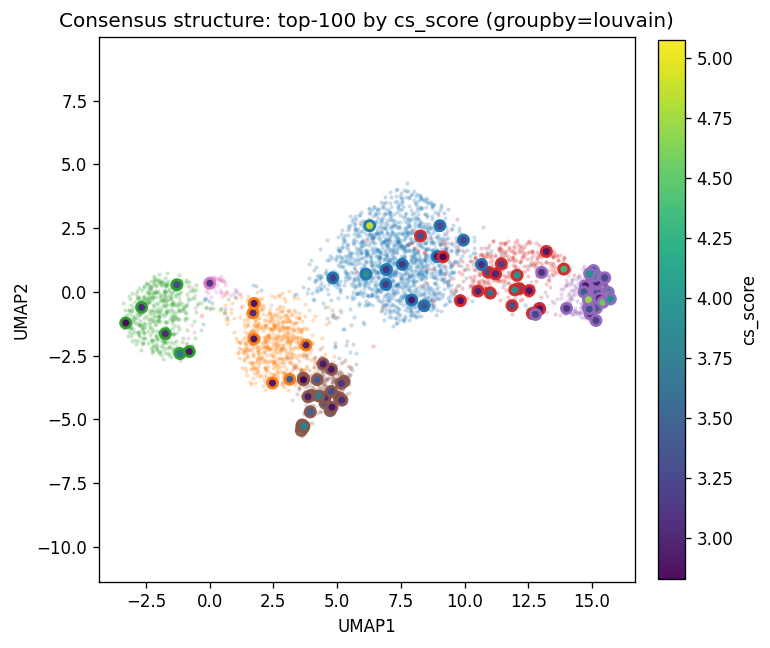

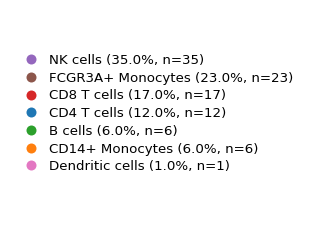

(<Figure size 336x210 with 1 Axes>, <Axes: >)

In [18]:
fig, ax, stats, legend = sg.pl.consensus_structure(
    ad,
    score_key="cs_score",
    groupby="louvain",
    topk=100,
    hi_size=36,
    outline_lw=1.8,
    print_legend=True,   # prints summary lines
)


sg.pl.legend_from_data(legend)


**Interpretation:** top-scoring cells are those most aligned with the learned delta directions. Use this to inspect which populations drive the condition difference.

In [19]:
ad

AnnData object with n_obs × n_vars = 3338 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'bulk_labels', 'S_score', 'G2M_score', 'phase', 'batch', 'cs_score'
    uns: 'batch_colors', 'louvain_colors', 'scgeo'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'rep', 'X_cs'

In [20]:
# choose one, but be explicit:
sc.pp.neighbors(ad, use_rep="X_pca", n_neighbors=15)      # typical
# or if you're using an integrated latent:
# sc.pp.neighbors(ad, use_rep="X_scvi", n_neighbors=15)


## 5) Mapping QC (optional): graph-native `map_query_to_ref`

### Why do this?
Once we split data into **reference** and **query**, we can ask a practical question:

> *For each query cell, which reference label does its neighborhood most support — and how confident is that assignment?*

This is useful when you have a real query dataset and want:
- a transferred label (predicted cell type / cluster)
- a confidence estimate (is the mapping decisive or ambiguous?)
- an out-of-distribution (OOD) flag (is this query cell poorly supported by the reference manifold?)

### What it requires
This block assumes you have:
- a **graph** in `adata.obsp['connectivities']`
- a `condition_key` that defines **ref/query partitions**
- a `label_key` that exists **in the reference** (e.g. `louvain` or `cell_type`)

If your notebook has not built a graph yet, you can safely run:
- `sc.pp.neighbors(adata)`

That does **not** change your expression matrix; it only constructs the kNN graph that the mapping QC depends on.

### What “predicted label” means here
The predicted label is the reference label that is most supported by the query cell’s neighborhood.
In PBMC, you generally expect:
- query cells in the T-cell manifold → predicted label corresponding to T-cell clusters
- query cells in monocyte manifold → monocyte-like predicted labels

If you see patches that look "wrong":
- **near boundaries** between clusters: ambiguous neighborhoods are expected
- **rare populations**: small reference support can yield unstable predictions
- **poor mixing / integration**: the query may sit in a region not well represented by ref, raising OOD or reducing confidence

In this notebook, because query is derived from the same dataset, predicted labels should look *mostly reasonable*.
Treat any weirdness as a cue to inspect the graph / preprocessing, not as a dramatic biological claim.



In [21]:
print(condition_key,cluster_key,group1,group0)

batch louvain new ref


In [22]:
RUN_MAPPING = True


In [23]:
if RUN_MAPPING:
    sg.tl.map_query_to_ref(
        ad,
        ref_key=condition_key,
        ref_value=group0,
        label_key=cluster_key,
        query_key=condition_key,
        query_value=group1,
        graph_key='connectivities',
        conf_method='entropy_margin',
        ood_method='connectivity_mass',
        store_key='map_query_to_ref',
        pred_key='scgeo_pred',
        conf_key='scgeo_conf',
        ood_key='scgeo_ood',
        reject_key='scgeo_reject',
    )


### How to read the mapping QC plots

These plots are intentionally *redundant views* of the same mapping output — each view highlights a different failure mode.

#### 1) Predicted label
Each **query** cell is assigned the reference label with the strongest neighborhood support.

What you want to see:
- large contiguous regions with consistent labels, matching the UMAP geometry

What to watch for:
- salt-and-pepper labels inside a well-formed cluster → likely ambiguous neighborhoods or underpowered reference support
- systematic "wrong" regions → possible graph issues (neighbors built on the wrong representation), batch effects, or mismatched label definitions

#### 2) Confidence
Confidence measures how decisively the neighborhood supports *one* reference label.

- **High confidence** inside well-separated populations is expected.
- **Lower confidence** at boundaries is expected (mixed neighborhoods).
- **Broad low-confidence regions** can indicate poor integration or an over-fragmented graph.

#### 3) OOD score
OOD (out-of-distribution) highlights query cells that are **weakly supported** by the reference manifold.

Common reasons:
- genuinely novel state present only in query
- technical shift (chemistry, depth, batch)
- reference is missing that population
- query cells are poorly connected in the graph (too few good neighbors)

In a toy split of the same PBMC dataset, OOD should generally be low, with occasional higher values at rare/edge populations.



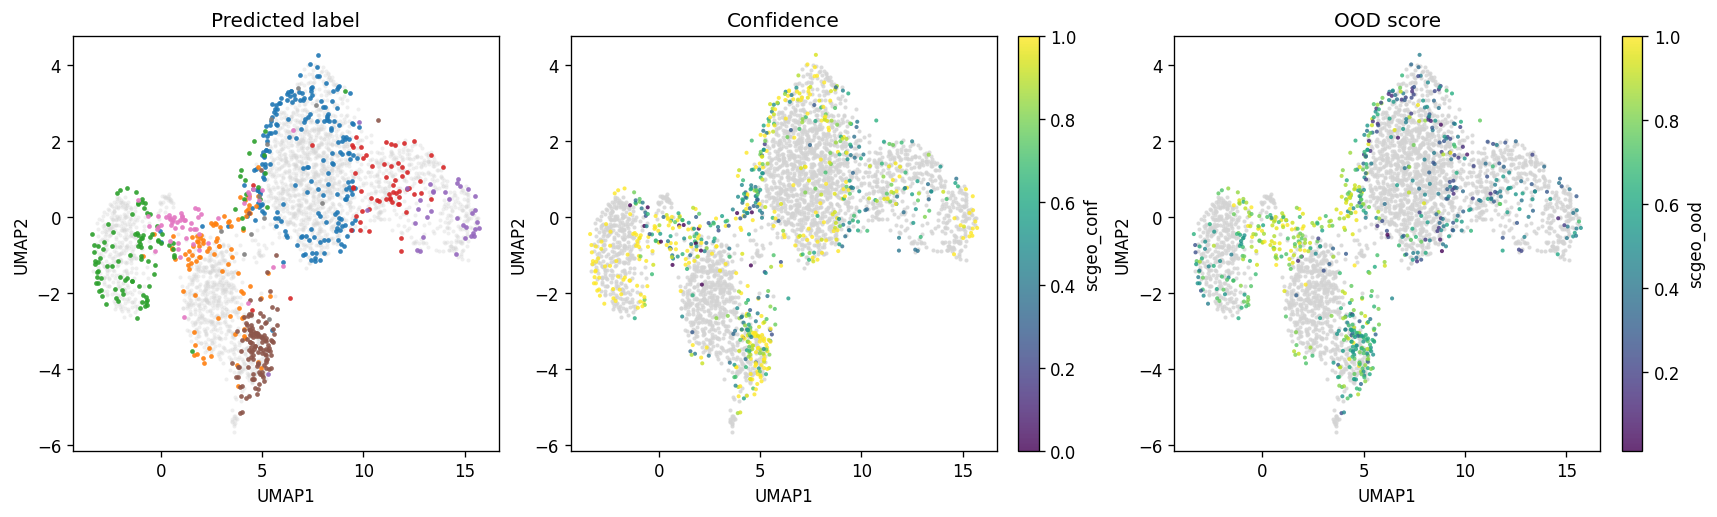

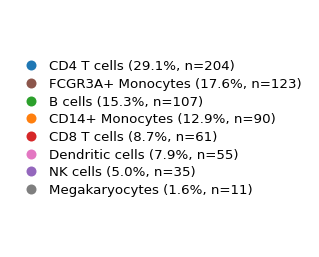

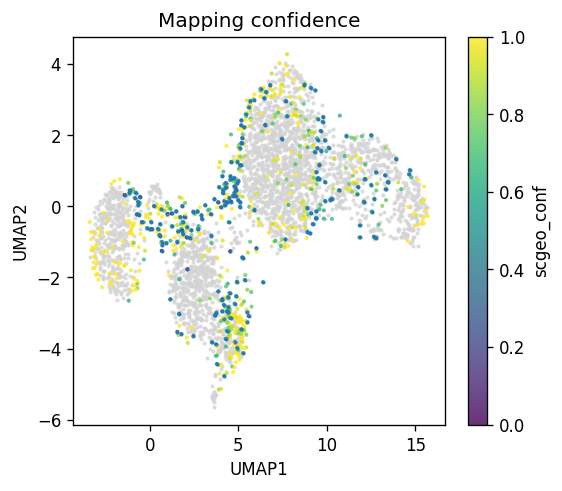

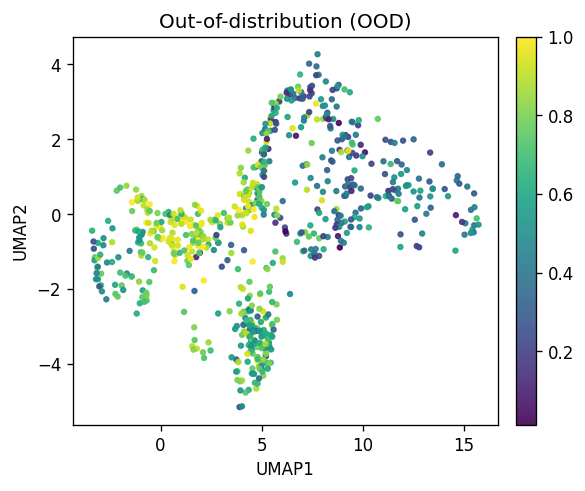

In [24]:
if RUN_MAPPING:
    fig, axes, legend_data = sg.pl.mapping_qc_panel(
        ad,
        pred_key="scgeo_pred",
        conf_key="scgeo_conf",
        ood_key="scgeo_ood",
        basis="umap",
        palette_from="louvain",       # << key fix: reuse louvain palette
        condition_key="batch",
        query_value="new",            # << show predictions for query cells only
        return_legend_data=True,
        show=True,
    )
    
    # tiny legend as separate output
    sg.pl.legend_from_data(legend_data)

    sg.pl.mapping_confidence_umap(ad, conf_key='scgeo_conf', basis='umap')
    sg.pl.ood_cells(ad, ood_key='scgeo_ood', basis='umap')


### Interpreting the mapping QC panel (graph-native `map_query_to_ref`)

This block visualizes **label transfer from the reference cells to the query cells** using the graph in `ad.obsp['connectivities']`.

#### 1) *Predicted label*
- Each query cell is colored by **`pred_key` (here: `scgeo_pred`)**, which is the **predicted reference label** produced by `sg.tl.map_query_to_ref(...)`.
- Because `label_key` was set to **`louvain`** in this notebook, `scgeo_pred` should be interpreted as **“the louvain label this query cell most resembles in the reference”**.
- If integration is reasonable, the predicted-label map should **track the existing PBMC manifold**:
  - the **B-cell island** should mostly predict “B cells”,
  - **CD14+/FCGR3A+ monocyte** regions should map to their respective monocyte labels,
  - **T cell** regions (CD4/CD8) should not collapse into a single unrelated label.

What it is **not**:
- It is **not** simply `sc.pl.umap(ad, color='louvain')` re-plotted. `sc.pl.umap(..., color='louvain')` shows the *assigned* cluster labels in `ad.obs['louvain']` for all cells.
- Here we are showing **a transferred label** (stored under `scgeo_pred`), optionally **restricted to query cells only** (so you see where the query maps *into* the reference label space).

Common “red flag” patterns:
- Large contiguous areas of the query all predicting a **single label** despite diverse structure (often indicates the graph is dominated by one dense region, or the query is poorly connected).
- Sharp boundaries that cut across obvious biological manifolds (often indicates batch separation or a missing neighbor graph).

#### 2) *Confidence* (`scgeo_conf`)
- Confidence summarizes how strongly a query cell’s neighborhood supports a single transferred label.
- With `conf_method='entropy_margin'`:
  - **High confidence** means the label distribution over neighbors is **peaked** (one label dominates).
  - **Low confidence** often appears at **boundaries / transitional regions** (e.g., CD4↔CD8 continuum) or where the query has weak connectivity to the reference.

How to read it:
- Expect higher confidence in **well-separated PBMC populations** (B cells, NK, monocytes).
- Expect lower confidence in **interfaces** (T cell subtypes, rare/ambiguous areas).

#### 3) *OOD score* (`scgeo_ood`)
- OOD (out-of-distribution) scores measure whether query cells look **unsupported by the reference graph**.
- With `ood_method='connectivity_mass'` (graph-based):
  - **High OOD** means a query cell has **little effective connectivity into the reference** (it “doesn’t land” anywhere confidently).
  - This can reflect **true novelty** (a cell state absent in the reference) *or* **technical mismatch** (batch shift, poor preprocessing, wrong neighbor graph, too aggressive filtering).

Practical interpretation in this demo:
- Because this is a *toy split* of the same PBMC dataset, truly novel biology is unlikely.
- So **clusters of high-OOD points** are more likely to indicate **graph/integration issues** (e.g., neighbors computed before/after a transformation, too few neighbors, or strong batch separation).

#### Quick consistency checks (recommended)
- Compare predicted-label structure against the known PBMC layout (B / T / NK / monocytes).
- Look for regions where **low confidence coincides with high OOD** (these are the most suspicious).
- If you want a strict sanity check, compute a confusion table for query cells:
  - `pd.crosstab(ad.obs.loc[is_query, 'louvain'], ad.obs.loc[is_query, 'scgeo_pred'])`



**Interpretation:**
- Confidence should be high where neighborhoods strongly support a single reference label.
- OOD flags query cells with weak support from the reference neighborhoods (possible novel states or poor integration).